# 1. Medical Cost Prediction – EDA & Modelleme
Bu notebook, Kaggle Medical Cost Personal Dataset kullanılarak sağlık sigortası yıllık masraf tahmini için veri analizi ve model geliştirme adımlarını içerir.

# 2. Kütüphaneler

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

pd.set_option("display.float_format", lambda x: f"{x:.2f}")

import warnings
warnings.filterwarnings("ignore")

# 3. Veriyi Yükleme

In [2]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.77,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.88,0,no,northwest,3866.86


# 4. Veri Bilgisi

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


# 5. Tanımlayıcı İstatistikler 

In [4]:
data.describe()

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


# 6. Eksik Değer Kontrolü

In [5]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# 7. Kategorik Değişken İncelemesi

In [6]:
for col in ["sex", "smoker", "region"]:
    print(f"\n{col} değerleri:")
    print(data[col].value_counts())


sex değerleri:
sex
male      676
female    662
Name: count, dtype: int64

smoker değerleri:
smoker
no     1064
yes     274
Name: count, dtype: int64

region değerleri:
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


# 8. Masraf (Charges) Dağılımı

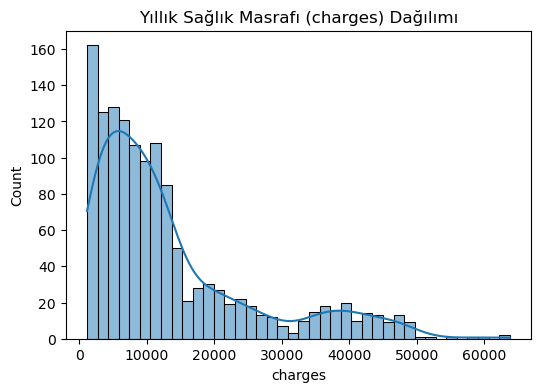

In [7]:
plt.figure(figsize=(6,4))
sns.histplot(data["charges"], kde=True, bins=40)
plt.title("Yıllık Sağlık Masrafı (charges) Dağılımı")
plt.show()

# 9. Yaş Dağılımı

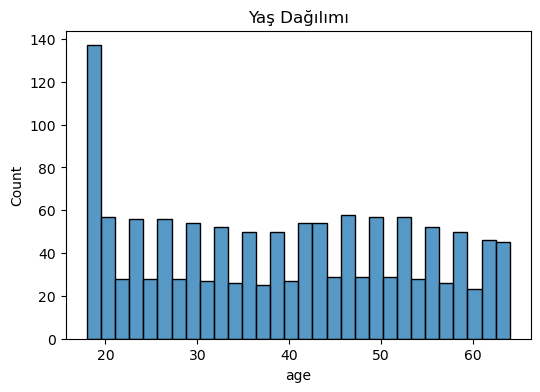

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(data["age"], kde=False, bins=30)
plt.title("Yaş Dağılımı")
plt.show()

# 10. Vücut Kitle İndeksi (BMI) Dağılımı

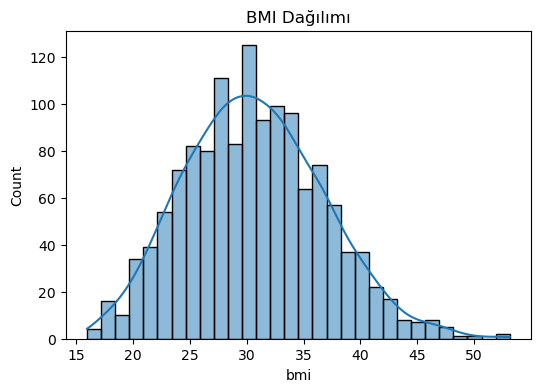

In [9]:
plt.figure(figsize=(6,4))
sns.histplot(data["bmi"], kde=True, bins=30)
plt.title("BMI Dağılımı")
plt.show()

# 11. Sigara Etkisi (Boxplot)

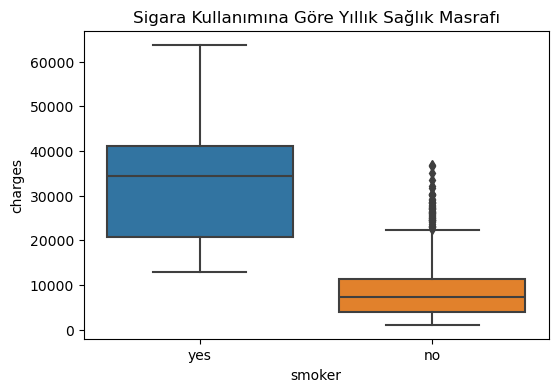

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(data=data, x="smoker", y="charges")
plt.title("Sigara Kullanımına Göre Yıllık Sağlık Masrafı")
plt.show()

# 12. Vücut Kitle İndeksi (BMI) ile Masraflar (Charges) (Sigara Ayrımı)

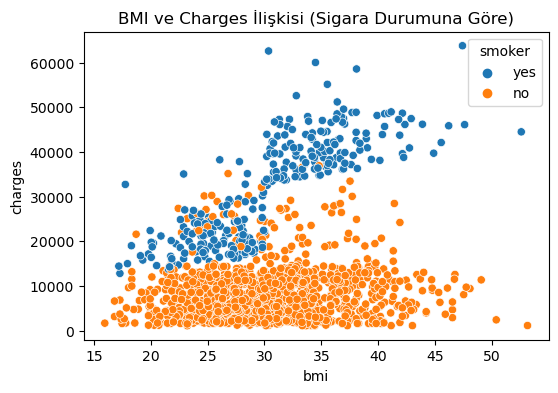

In [11]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=data, x="bmi", y="charges", hue="smoker")
plt.title("BMI ve Charges İlişkisi (Sigara Durumuna Göre)")
plt.show()

# 13. Özellik Seçimi

In [12]:
feature_cols = ["age", "sex", "bmi", "smoker"]
X = data[feature_cols]
y = data["charges"]

# 14. Eğitim/Test Bölünmesi

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((1070, 4), (268, 4))

# 15. Ön İşleme Pipeline

In [14]:
numeric_features = ["age", "bmi"]
categorical_features = ["sex", "smoker"]

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 16. Modellerin Tanımlanması

In [15]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(
        random_state=42
    )
}

results = []
best_model = None
best_r2 = -np.inf

# 17. Modellerin Eğitimi ve Karşılaştırma

In [16]:
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })
    
    print(f"\nModel: {name}")
    print(f"  MAE  : {mae:.2f}")
    print(f"  RMSE : {rmse:.2f}")
    print(f"  R^2  : {r2:.3f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_model = pipe

results_df = pd.DataFrame(results)
results_df


Model: LinearRegression
  MAE  : 4260.99
  RMSE : 5874.99
  R^2  : 0.778

Model: RandomForest
  MAE  : 2628.15
  RMSE : 4827.89
  R^2  : 0.850

Model: GradientBoosting
  MAE  : 2543.11
  RMSE : 4501.51
  R^2  : 0.869


,model,MAE,RMSE,R2
0,LinearRegression,4260.99,5874.99,0.78
1,RandomForest,2628.15,4827.89,0.85
2,GradientBoosting,2543.11,4501.51,0.87


# 18. En İyi Modelin Kaydedilmesi

In [17]:
import os
os.makedirs("../models", exist_ok=True)

joblib.dump(best_model, "../models/best_model.pkl")

print("En iyi model kaydedildi: ../models/best_model.pkl")

En iyi model kaydedildi: ../models/best_model.pkl


# 19. Yeni Müşteri Tahmini

In [18]:
new_customer = pd.DataFrame({
    "age": [45],
    "sex": ["male"],
    "bmi": [28.7],
    "smoker": ["yes"]
})

predicted_cost = best_model.predict(new_customer)[0]
print(f"Yeni müşteri için tahmin edilen yıllık sağlık masrafı: {predicted_cost:.2f}")

Yeni müşteri için tahmin edilen yıllık sağlık masrafı: 25945.41


# 20. Feature Importance (Opsiyonel)

In [19]:
if hasattr(best_model.named_steps["model"], "feature_importances_"):
    # OneHotEncoder sonrası feature isimlerini çıkaralım
    ohe = best_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]
    ohe_features = ohe.get_feature_names_out(["sex", "smoker"])
    
    feature_names = ["age", "bmi"] + list(ohe_features)
    importances = best_model.named_steps["model"].feature_importances_
    
    fi = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False)
    
    fi
else:
    print("Bu model feature importance desteklemiyor.")